# Milestone 1: Environment Preparation (10 points by 10/30)


In [1]:
# install nni
! npm install -g localtunnel
! pip install nni

# other dependencies
! pip install torch
import time

# because google colab is hosted on a google ip;
# we first need to download ngrok and unzip it
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

# create our project folder
! mkdir -p semseg_repo

# clone remote repository from repo we cloned from seed
! git clone https://github.com/SebastianAlcock/CS301101-Semantic-Segmentation-of-Satellite-Imagery semseg_repo/nni
# access ngrok with our personal authtoken
! ./ngrok authtoken 2Gova0foGFQhbYO3XBasI3LxD0P_5htGJmi8jFj2P6uf4VWaS

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
added 22 packages from 22 contributors in 1.453s
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56.0 MB 1.2 MB/s 
     |████████████████████████████████| 51 kB 7.4 MB/s 
     |████████████████████████████████| 106 kB 83.7 MB/s 
     |████████████████████████████████| 130 kB 78.8 MB/s 
     |████████████████████████████████| 127 kB 83.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-11-19 18:39:02--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 18.205.222.128, 54.161.241.46, ...
Connecting to bin.equinox.i

# Milestone 2: Perform Baseline Semantic Segmentation (30 points by 11/6)

In [ ]:
import os
import cv2
import numpy as np
from google.colab import files

! pip install patchify
! pip install segmentation-models
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# https://youtu.be/jvZm8REF2KY
"""
Explanation of using RGB masks: https://youtu.be/sGAwx4GMe4E
https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery
The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:
Building: #3C1098
Land (unpaved area): #8429F6
Road: #6EC1E4
Vegetation: #FEDD3A
Water: #E2A929
Unlabeled: #9B9B9B
Use patchify....
Tile 1: 797 x 644 --> 768 x 512 --> 6
Tile 2: 509 x 544 --> 512 x 256 --> 2
Tile 3: 682 x 658 --> 512 x 512  --> 4
Tile 4: 1099 x 846 --> 1024 x 768 --> 12
Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16
Tile 6: 859 x 838 --> 768 x 768 --> 9
Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56
Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40
Total 9 images in each folder * (145 patches) = 1305
Total 1305 patches of size 256x256
"""

import os
import cv2
import sys
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

root_directory = 'semseg_repo/nni/Semantic segmentation dataset/'

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path) #List of all image names in this subdirectory
        images.sort()
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                #print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                
#Now do the same as above for masks
#For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        masks.sort()
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                #print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

#sys.exit("Exited early")

############################################################################
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F
Example: RGB --> R=201, G=, B=
R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)
Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152
"""
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
#print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

# Now replace RGB to integer values to be used as labels.
# Find pixels with combination of RGB for the above defined arrays...
# if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

#print("Unique labels in label dataset are: ", np.unique(labels))

############################################################################

n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

############################################################################

#Parameters for model

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

from semseg_repo.nni.simple_multi_unet_model import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()


history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save('models/satellite_standard_unet_100epochs.hdf5')

############################################################################

#Plot the training and validation accuracy and loss at each epoch

history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

##################################

from keras.models import load_model
model = load_model("models/satellite_standard_unet_100epochs.hdf5",
                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#Normalized values
y_pred_argmax_normalized = tf.math.divide(tf.math.subtract(y_pred_argmax, tf.math.reduce_min(y_pred_argmax)), tf.math.subtract(tf.math.reduce_max(y_pred_argmax), tf.math.reduce_min(y_pred_argmax)))
y_test_argmax_normalized = tf.math.divide(tf.math.subtract(y_test_argmax, tf.math.reduce_min(y_test_argmax)), tf.math.subtract(tf.math.reduce_max(y_test_argmax), tf.math.reduce_min(y_test_argmax)))

precision_list = []
recall_list = []
threshold_list = np.arange(0.0, 1.0, 0.001, dtype=float)
for threshold in threshold_list:
  precision_sum = 0
  recall_sum = 0

  for i in range(n_classes):
    #Using built in keras function for Precision
    precision_keras = tf.keras.metrics.Precision(class_id = i, thresholds = threshold)
    precision_keras.update_state(y_test_argmax_normalized, y_pred_argmax_normalized)
    precision_sum += precision_keras.result().numpy()
    #Using built in keras function for Recall
    recall_keras = tf.keras.metrics.Recall(class_id = i, thresholds = threshold)
    recall_keras.update_state(y_test_argmax_normalized, y_pred_argmax_normalized)
    recall_sum += recall_keras.result().numpy()

  mean_precision = precision_sum / n_classes
  mean_recall = recall_sum / n_classes

  precision_list.append(mean_precision)
  recall_list.append(mean_recall)

recall_list.append(0)
precision_list.append(1)

recall_list.insert(0, 1)
precision_list.insert(0, 0)

plt.plot(recall_list, precision_list, 'b')
plt.title("Precision Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Presicion')

#######################################################################

#Demonstrate on a few images

import random
for i in range(10): 
  test_img_number = random.randint(0, len(X_test) - 1)
  test_img = X_test[test_img_number]
  ground_truth=y_test_argmax[test_img_number]
  test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]


  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth)
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img)
  plt.show()

#####################################################################

# Milestone 3 (CS301-101 ONLY): Hyperparameter Optimization (30 points by 11/20)

### NNI Experiment:

In [ ]:
# install nni
! npm install -g localtunnel
! pip install nni

# other dependencies
! pip install torch
import time

# because google colab is hosted on a google ip;
# we first need to download ngrok and unzip it
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

# create our project folder
! mkdir -p semseg_repo

# clone remote repository from repo we cloned from seed
! git clone https://github.com/SebastianAlcock/CS301101-Semantic-Segmentation-of-Satellite-Imagery semseg_repo/nni
# access ngrok with our personal authtoken
! ./ngrok authtoken 2Gova0foGFQhbYO3XBasI3LxD0P_5htGJmi8jFj2P6uf4VWaS

# imports
import os
import cv2
import numpy as np
from google.colab import files

! pip install patchify
! pip install segmentation-models
! pip install tensorflow
! pip install retry_requests

# !python semseg_repo/nni/model.py

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
added 22 packages from 22 contributors in 1.703s
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56.0 MB 5.8 MB/s 
     |████████████████████████████████| 106 kB 83.8 MB/s 
     |████████████████████████████████| 51 kB 9.3 MB/s 
     |████████████████████████████████| 130 kB 81.2 MB/s 
     |████████████████████████████████| 127 kB 81.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-11-18 20:15:00--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.161.241.46, 54.237.133.81, ...
Connecting to bin.equinox.io

In [ ]:
from nni.experiment import Experiment


experiment = Experiment('local')

search_space = {
    'learning_rate': {'_type': 'loguniform', '_value': [0.0001, 0.01]},
    'activation_type': {'_type': 'choice', '_value': ['relu', 'tanh', 'swish', None]},
    'batch_size': {'_type': 'choice', '_value': [2, 4, 8, 16]}
    # 'dropout_rate': {'_type': 'uniform', '_value': [0.1, 0.3]}
}

experiment.config.trial_command = 'python3 model.py'
experiment.config.trial_code_directory = '/content/semseg_repo/nni'
experiment.config.search_space = search_space
experiment.config.tuner.name = 'TPE'
experiment.config.tuner.class_args['optimize_mode'] = 'maximize'
experiment.config.max_trial_number = 100
experiment.config.trial_concurrency = 5
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
get_ipython().system_raw('./ngrok http 5000 &')

! curl -s http://localhost:4040/api/tunnels

{"tunnels":[{"name":"command_line","uri":"/api/tunnels/command_line","public_url":"https://d78c-34-125-156-146.ngrok.io","proto":"https","config":{"addr":"http://localhost:5000","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}},{"name":"command_line (http)","uri":"/api/tunnels/command_line%20%28http%29","public_url":"http://d78c-34-125-156-146.ngrok.io","proto":"http","config":{"addr":"http://localhost:5000","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}}],"uri":"/api/tunnels"}


In [ ]:
experiment.run(5000)

[2022-11-18 20:15:30] Creating experiment, Experiment ID: a6tr08zw


INFO:nni.experiment:Creating experiment, Experiment ID: ${CYAN}a6tr08zw


[2022-11-18 20:15:30] Starting web server...


INFO:nni.experiment:Starting web server...


[2022-11-18 20:15:31] Setting up...


INFO:nni.experiment:Setting up...


[2022-11-18 20:15:31] Web portal URLs: http://127.0.0.1:5000 http://172.28.0.2:5000


INFO:nni.experiment:Web portal URLs: ${CYAN}http://127.0.0.1:5000 http://172.28.0.2:5000


In [ ]:
!nnictl stop --all

INFO:  Stopping experiment jpg4s7ku
INFO:  Stop experiment success.


### Running optimized model:

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 256, 256, 16  448         ['input_6[0][0]']                
                                )                                                           

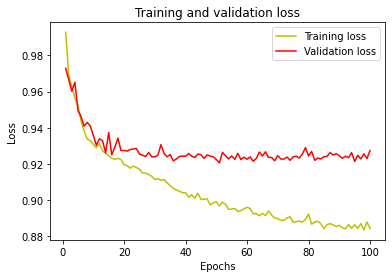

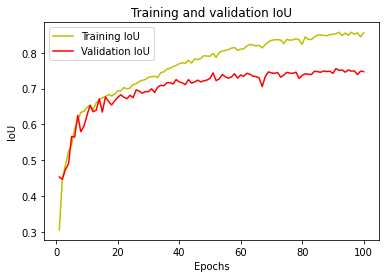

9/9 [==============================] - 0s 21ms/step
Mean IoU = 0.5970888
1/1 [==============================] - 0s 23ms/step


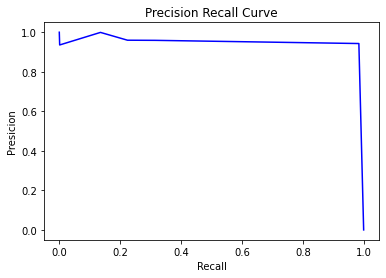

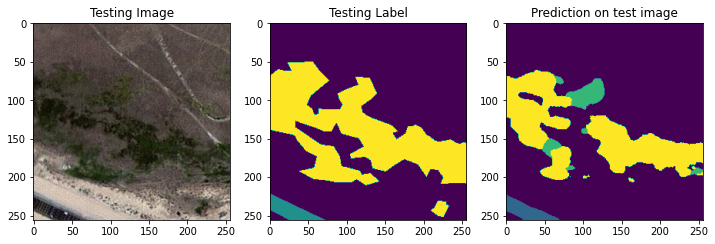

1/1 [==============================] - 0s 39ms/step


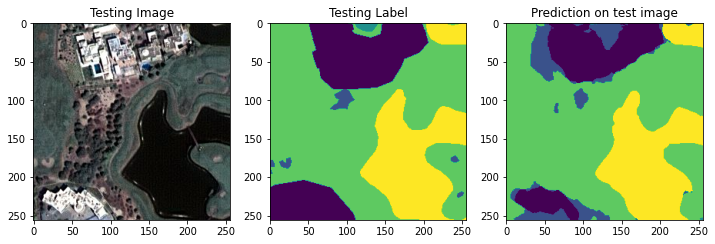

1/1 [==============================] - 0s 21ms/step


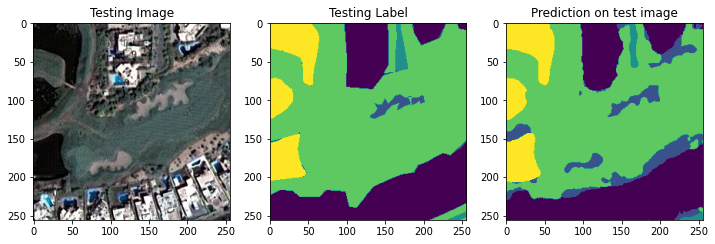

1/1 [==============================] - 0s 21ms/step


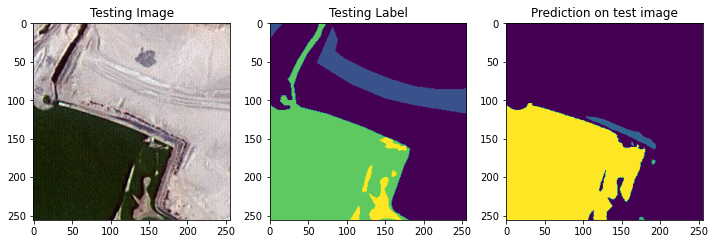

1/1 [==============================] - 0s 20ms/step


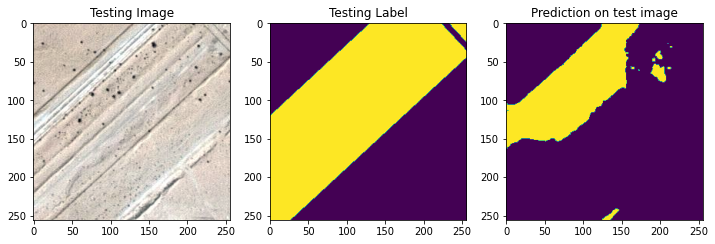

1/1 [==============================] - 0s 20ms/step


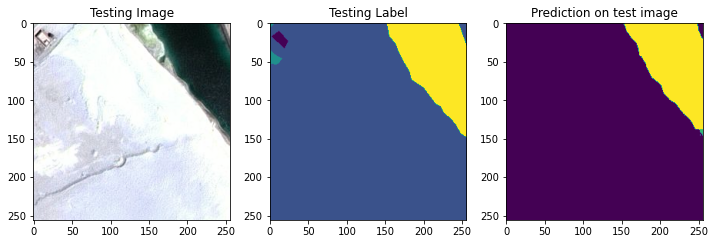

1/1 [==============================] - 0s 20ms/step


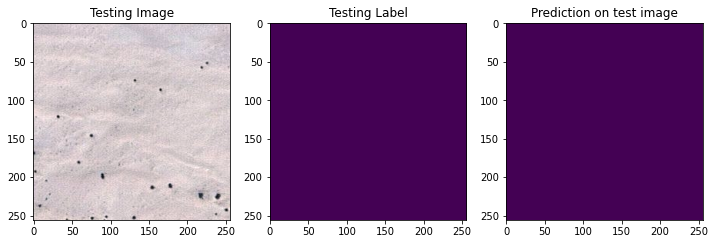

1/1 [==============================] - 0s 20ms/step


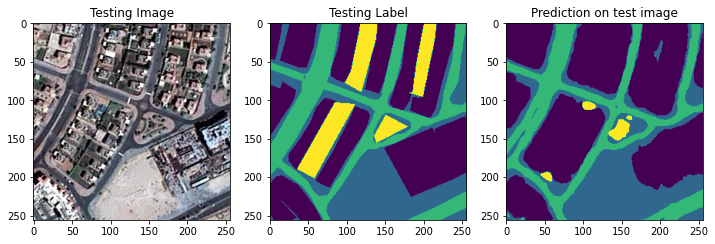

1/1 [==============================] - 0s 20ms/step


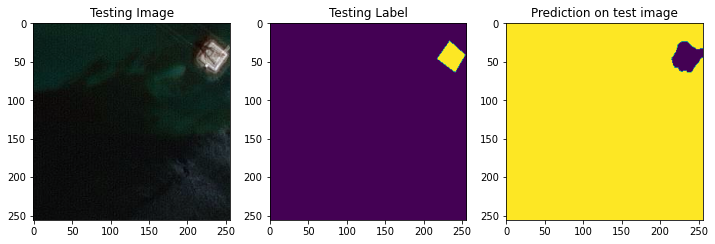

1/1 [==============================] - 0s 21ms/step


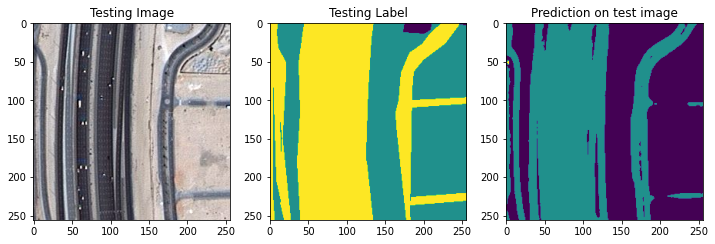

In [7]:
import os
import cv2
import numpy as np
from google.colab import files

! pip install patchify
! pip install segmentation-models
! pip install tensorflow

import os
import cv2
import sys
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

root_directory = 'semseg_repo/nni/Semantic segmentation dataset/'

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path) #List of all image names in this subdirectory
        images.sort()
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                #print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                
#Now do the same as above for masks
#For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        masks.sort()
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                #print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

#sys.exit("Exited early")

############################################################################

#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
#print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

# Now replace RGB to integer values to be used as labels.
# Find pixels with combination of RGB for the above defined arrays...
# if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

#print("Unique labels in label dataset are: ", np.unique(labels))

############################################################################

n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

############################################################################

#Optimized parameters for model

optimized_params = {
    'learning_rate': 0.0004678418249479461,
    'activation_type': 'relu',
    'batch_size': 4
}

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

from semseg_repo.nni.simple_multi_unet_model_optimized import multi_unet_model_optimized, jacard_coef  

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model_optimized(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS, activation_type=optimized_params['activation_type'])

model = get_model()

adam = tf.keras.optimizers.Adam(learning_rate=optimized_params['learning_rate'])
model.compile(optimizer=adam, loss=total_loss, metrics=metrics)

model.summary()


history1 = model.fit(X_train, y_train, 
                     batch_size=optimized_params['batch_size'], 
                     epochs=100, 
                     validation_data=(X_test, y_test))

model.save('models/satellite_standard_unet_100epochs_optimized.hdf5')

############################################################################

#Plot the training and validation accuracy and loss at each epoch

history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

##################################

from keras.models import load_model
model = load_model("models/satellite_standard_unet_100epochs_optimized.hdf5",
                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#Normalized values
y_pred_argmax_normalized = tf.math.divide(tf.math.subtract(y_pred_argmax, tf.math.reduce_min(y_pred_argmax)), tf.math.subtract(tf.math.reduce_max(y_pred_argmax), tf.math.reduce_min(y_pred_argmax)))
y_test_argmax_normalized = tf.math.divide(tf.math.subtract(y_test_argmax, tf.math.reduce_min(y_test_argmax)), tf.math.subtract(tf.math.reduce_max(y_test_argmax), tf.math.reduce_min(y_test_argmax)))

precision_list = []
recall_list = []
threshold_list = np.arange(0.0, 1.0, 0.001, dtype=float)
for threshold in threshold_list:
  precision_sum = 0
  recall_sum = 0

  for i in range(n_classes):
    #Using built in keras function for Precision
    precision_keras = tf.keras.metrics.Precision(class_id = i, thresholds = threshold)
    precision_keras.update_state(y_test_argmax_normalized, y_pred_argmax_normalized)
    precision_sum += precision_keras.result().numpy()
    #Using built in keras function for Recall
    recall_keras = tf.keras.metrics.Recall(class_id = i, thresholds = threshold)
    recall_keras.update_state(y_test_argmax_normalized, y_pred_argmax_normalized)
    recall_sum += recall_keras.result().numpy()

  mean_precision = precision_sum / n_classes
  mean_recall = recall_sum / n_classes

  precision_list.append(mean_precision)
  recall_list.append(mean_recall)

recall_list.append(0)
precision_list.append(1)

recall_list.insert(0, 1)
precision_list.insert(0, 0)

plt.plot(recall_list, precision_list, 'b')
plt.title("Precision Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Presicion')

#######################################################################

#Demonstrate on a few images

import random
for i in range(10): 
  test_img_number = random.randint(0, len(X_test) - 1)
  test_img = X_test[test_img_number]
  ground_truth=y_test_argmax[test_img_number]
  test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]


  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth)
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img)
  plt.show()